# Support Vector Machines

This project uses a support vector machine (SVM) classifier to diagnose heart disease in patients given a variety of medical data ([data source](https://www.kaggle.com/ronitf/heart-disease-uci)). The data includes 14 different attributes, including factors such as age, gender, resting heart rate, fasting blood sugar, presence of exercise-induced angina, etc.

## 1. SVM Review

Before we jump in, let's review what support vector machines are and how we use them. Firstly, an SVM is a type of supervised learning algorithm that can be used for regression, classification, and anomoly detection purposes. You may be wondering why we don't use a simple linear regression or multi-class logistic regression for these same types of problems, and you're not wrong! It often makes sense to use a simpler model. However, if the number of attributes is large, or if we're in some other way operating in high-dimensional spaces, then SVM's are a solid option.

SVM's are very similar to logistic regressions, so let's start there. Below is the cost function of a logistic regression (note: if this looks unfamiliar or if you'd like a recap of this cost function, see [my other project](https://github.com/c-coyne/data_science_portfolio/tree/main/Multi-Class%20Classification%20(Handwritten%20Digits)) using logistic regression multi-class classification to recognize handwritten numbers).

<img src="2020-12-15 log reg cost function.PNG" align="center"/>

Above, we essentially have two cost function components (one for y=1 and one for y=0) and a regularization parameter. This will be very similar in SVM's, but we first have to address a few differences. Firstly, logistic regression provides a *probability* that the label fits, then uses the highest probability across multiple models to identify the sample. SVM's choose only 1 or 0, so they don't occupy any of the middle ground. The hypothesis function for SVM's is therefore:

<img src="2020-12-15 hypothesis function.PNG" align="center"/>

Additionally, SVM's drop the 1/m scalar in the logistic regression cost equation, and the lambda variable is typically swapped for C = 1/lambda.

Alright, let's take a look below at the SVM cost function. While it may look slightly different, it has all of the same components as the logistic regression cost function above.

<img src="2020-12-15 svm cost function.PNG" align="center"/>

Good. With that understood, we can begin to apply an SVM model to our data. Let's get started.

## 1. Example SVM Classifiers

Before we jump in, let's take a look at what an SVM classifier can do. We'll build both a linear and nonlinear classifer as examples.

First, let's set up the various libraries that we'll need in this project.

In [1]:
# Import required libraries
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.svm import SVC

# Ignore convergence warnings of solver using less than the max number of iterations
import warnings
warnings.filterwarnings('ignore')

### 1.1 Example Linear SVM

Next, let's import some data.

In [2]:
sample_1 = scipy.io.loadmat('sample_data_1.mat')
X = sample_1["X"]
y = sample_1["y"]

Let's plot what we have. We'll need to divide the dataset into y=1 and y=0 to properly visualize the classes we're trying to distinguish.

In [3]:
def posNeg(y):
    y = y.flatten()
    pos = (y==1)
    neg = (y==0)
    return(pos, neg)

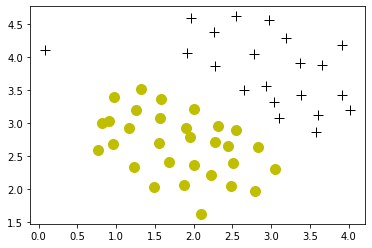

In [4]:
pos, neg = posNeg(y)
plt.plot(X[:,0][pos], X[:,1][pos], "k+", markersize=10)
plt.plot(X[:,0][neg], X[:,1][neg], "yo", markersize=10)
plt.show()

Let's train an SVM model on the dataset above. It'll find a linear boundary line optimized to the dataset, and will be adjustable based on our decision for model hyperparameters. First, we'll write our training function.

In [5]:
def svm_train(X, y, C, kernelFunction, tol=1e-3, max_passes=-1, sigma=0.1):
    """Trains an SVM classifier"""
    
    y = y.flatten()

    # If we're using a Gaussian kernel...
    if kernelFunction == "gaussian":
        clf = svm.SVC(C = C, kernel="precomputed", tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(gram_matrix(X,X, sigma=sigma), y)

    # If we're using a linear or rbf kernel...
    else:
        clf = svm.SVC(C = C, kernel=kernelFunction, tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(X, y)

Then, we can use the training function with a variety of C values to build models.

In [6]:
# Train the first model with C = 1
C = 1
model1 = svm_train(X, y, C, "linear", 1e-3, 20)

# Train the second model with C = 10
C = 4
model2 = svm_train(X, y, C, "linear", 1e-3, 20)

# Train the third model with C = 100
C = 100
model3 = svm_train(X, y, C, "linear", 1e-3, 20)

#visualizeBoundaryLinear(X, y, model)

[LibSVM][LibSVM][LibSVM]

Finally, let's visualize our models.

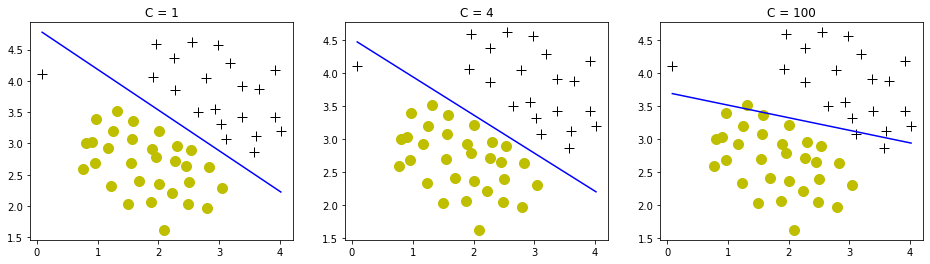

In [7]:
plt.figure(figsize=(16,4))
models = [model1, model2, model3]
C = [1, 4, 100]

for i in range(3):
    plt.subplot(1, 3, i+1)
    m = models[i].coef_[0]
    b = models[i].intercept_[0]
    xp = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yp = - (m[0] * xp + b) / m[1]
    plt.plot(X[:,0][pos], X[:,1][pos], "k+", markersize=10)
    plt.plot(X[:,0][neg], X[:,1][neg], "yo", markersize=10)
    plt.plot(xp, yp, 'b-')
    plt.title("C = {}".format(C[i]))
plt.show()

Above we can see that the boundary line determined by the SVM classifier is highly dependent on the value of C and the presence of outliers. With low C value, the model is relatively insensitive to outliers, and fits a boundary line more or less in line with what we'd expect, and what we may draw ourselves. On the other hand, a high C value results in the model trying it's best to fit all data into respective classes, even the outliers, which creates a line that may not fit quite as well. It all depends on the dataset.

### 1.2 Example Non-Linear SVM

While the dataset above was rather simple and could be classified by means of a linear boundary line, often we do not have this luxury. Let's pull another dataset and show how we'd use a non-linear boundary to classify two populations.

Before we do that, though, we first need to set up a few functions. The first is the Gaussian kernel. Briefly, a kernel is an algorithm that transforms the data into a different form. For instance, the Gaussian kernel has the shape of a normal distribution (in 3D space), and determines the distance between two points based on that setup. We'll use the Gaussian kernel in this example. The equation for this kernel is shown below: 

<img src="2020-12-12 gaussian kernel.PNG" align="center"/>

In [8]:
def gaussian_kernel(xi, xj, sigma=0.1):
    
    # Verify that each of xi and xj are column vectors
    xi, xj = xi.flatten(), xj.flatten()
    
    # Calculate the Gaussian kernel
    kernel = 0
    kernel = np.exp(- (np.sum((xi-xj)**2)) / (2*sigma**2) )
    
    # Return the Gaussian kernel
    return kernel

Next, we'll need the gram matrix. The gram matrix is simply a transposed matrix multiplied by the original matrix, resulting in all possible inner products. This facilitates calculation of the (Gaussian, in our case) kernel function.

<img src="2020-12-17 gram matrix.PNG" align="center"/>

In [9]:
def gram_matrix(xi, xj, K_function=gaussian_kernel, sigma=0.1):

    gram_matrix = np.zeros((xi.shape[0], xj.shape[0]))
    for i, x1 in enumerate(xi):
        for j, x2 in enumerate(xj):
            gram_matrix[i, j] = K_function(x1, x2, sigma)
    return gram_matrix

With those functions defined, let's plot the data and get a look at the boundary we're trying to build.

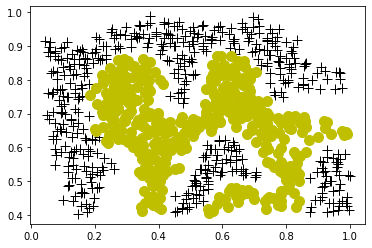

In [10]:
sample_1 = scipy.io.loadmat('sample_data_2.mat')
X = sample_1["X"]
y = sample_1["y"]
pos, neg = posNeg(y)
plt.plot(X[:,0][pos], X[:,1][pos], "k+", markersize=10)
plt.plot(X[:,0][neg], X[:,1][neg], "yo", markersize=10)
plt.show()

You can imagine above how you might draw a boundary between the two groups. Let's build an SVM classifier to do the same.

In [11]:
C = 1
sigma = 0.1
model = svm_train(X, y, C, "gaussian", sigma=sigma)

[LibSVM]

Our model is now trained. Let's add the resulting boundary to the plot of our data.

In [12]:
x1plot = np.linspace(X[:,0].min(), X[:,0].max(), 100).T
x2plot = np.linspace(X[:,1].min(), X[:,1].max(), 100).T
xi, xj = np.meshgrid(x1plot, x2plot)
vals = np.zeros(xi.shape)
for i in range(xi.shape[1]):
    this_x = np.column_stack((xi[:, i], xj[:, i]))
    vals[:, i] = model.predict(gram_matrix(this_x, X))

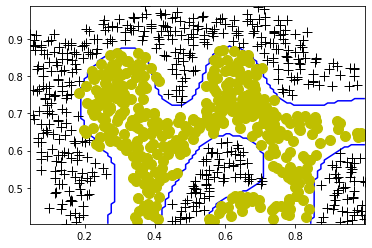

In [13]:
# Plot the data
plt.plot(X[:,0][pos], X[:,1][pos], "k+", markersize=10)
plt.plot(X[:,0][neg], X[:,1][neg], "yo", markersize=10)

# Plot the SVM boundary
plt.contour(xi, xj, vals, colors="blue", levels=[0,0])
plt.show(block=False)

Not bad! That classifier neatly fit the data and drew a non-linear boundary line between classes.

## 2. Import Data

The above examples provide a bit more context into how SVM classifiers work and what you can do with them. Let's apply the same strategy to the problem of interest and build an SVM classifier to diagnose heart disease in patients given other medical info on the patient. This will be a bit trickier to conceptualize, because instead of 2-dimension x1 & x2 data, we now have 13 attributes that are being used to predict our target values.

First, let's read in our data.

In [14]:
import pandas as pd

# Read data from .csv file into pandas dataframe
df = pd.read_csv('heart.csv')

# The columns are: 1 = age, 2 = sex, 3 = level of chest pain, 4 = resting blood pressure, 
# 5 = serum cholesterol in mg/dl, 6 = fasting blood sugar > 120 mg/dl, 7 = resting electrocardiographic
# results, 8 = maximum heart rate achieved, 9 = exercise-induced angina, 10 = ST depression in electrocardiogram
# induced by exercise relative to rest, 11 = the slope of the peak exercise ST segment, 12 = number of major
# vessels colored by fluoroscopy, 13 = thalium stress test result (3 = normal, 6 = fixed defect, 7 = reversible effect)

# Print the first 10 rows to get an idea of what the dataframe looks like
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## 3. Visualize & Explore Data

Let's look at each of the attributes in our dataset to get a better understanding of what we're dealing with.

In [15]:
# Divide up our data columns into categorical and numerical
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

For the categorical attributes, let's build pie charts and histograms of the data.

In [16]:
# Create a set of labels to be used in our pie plots
labels = []

# Add labels for sex (1=male, 0=female)
labels.append(['Male', 'Female'])
# Add labels for chest pain type
labels.append(['Type 1', 'Type 3', 'Type 2', 'Type 4'])
# Add labels for fasting blood sugar
labels.append(['< 120 mg/dl', '> 120 mg/dl'])
# Add labels for resting electrocardiographic results
labels.append(['1', '0', '2'])
# Add labels for exercise-induced angina (1=yes, 0=no)
labels.append(['No', 'Yes'])
# Add labels for slope of peak exercise ST segment
labels.append(['2', '1', '0'])
# Add labels for number of major vessels (0-3) colored by fluoroscopy
labels.append(['0 vessels', '1 vessel', '2 vessels', '3 vessels', '4 vessels'])
# Add labels for thalium stress test result
labels.append(['Normal', 'Fixed Defect', 'Reversible Defect', 'Other'])
# Add labels for target
labels.append(['Positive Diagnosis', 'Negative Diagnosis'])

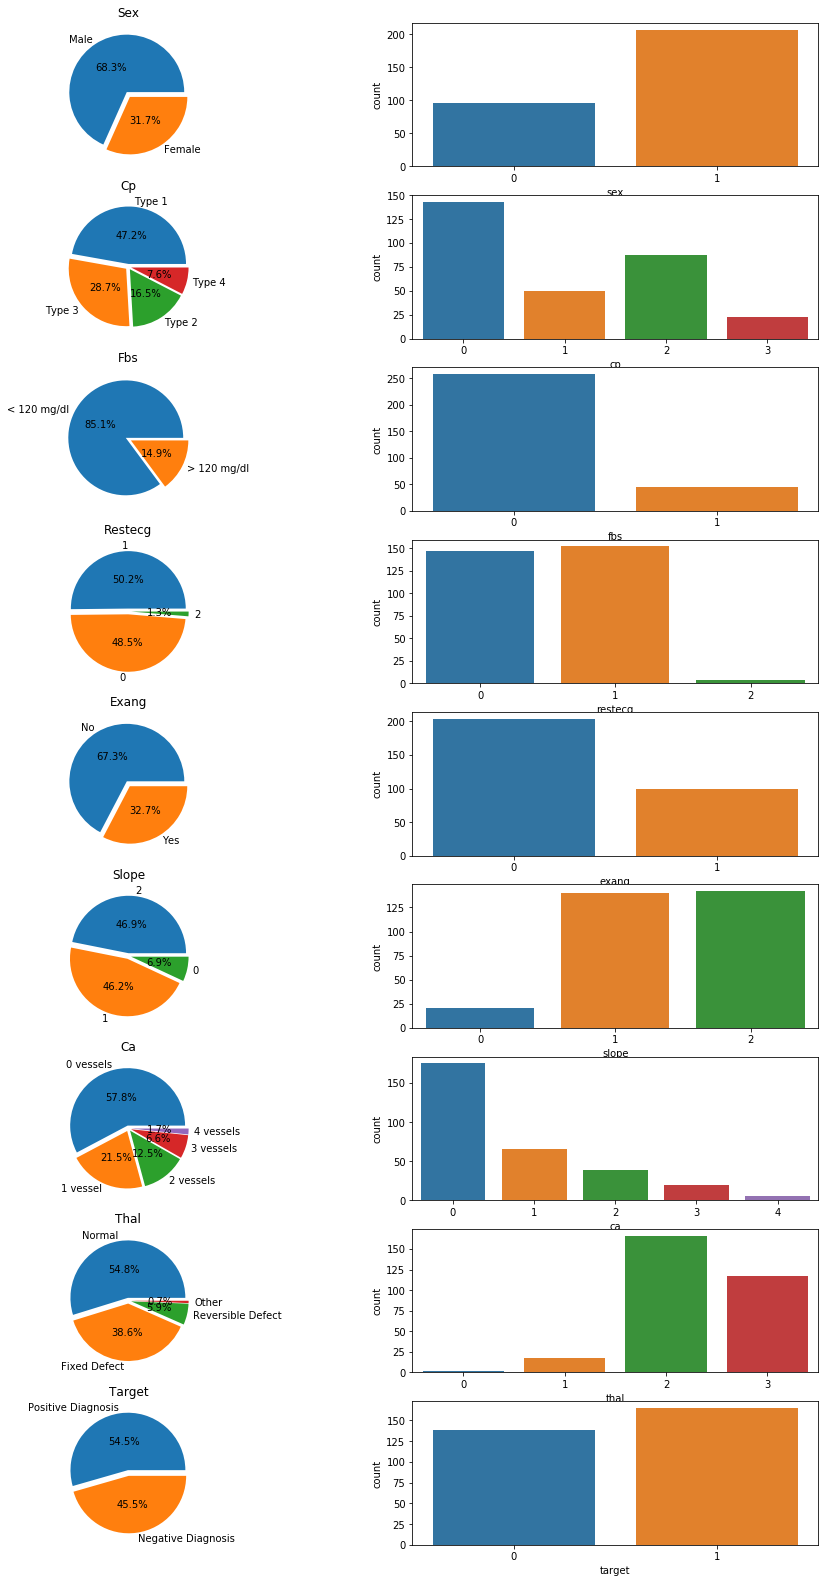

In [17]:
import seaborn as sns

plt.figure(figsize=(16,28))
lab_count = 0
count = 1
for col in cat_cols:
    plt.subplot(9, 2, count)
    label = labels[lab_count]
    plt.pie(x=df[col].value_counts(), autopct="%.1f%%", explode=[0.05]*len(label), labels=label, pctdistance=0.5)
    plt.title(col.capitalize())
    lab_count +=1
    count += 1
    plt.subplot(9, 2, count)
    sns.countplot(col, data=df)
    count+=1

For the numerical attributes, let's show box plots and distributions.

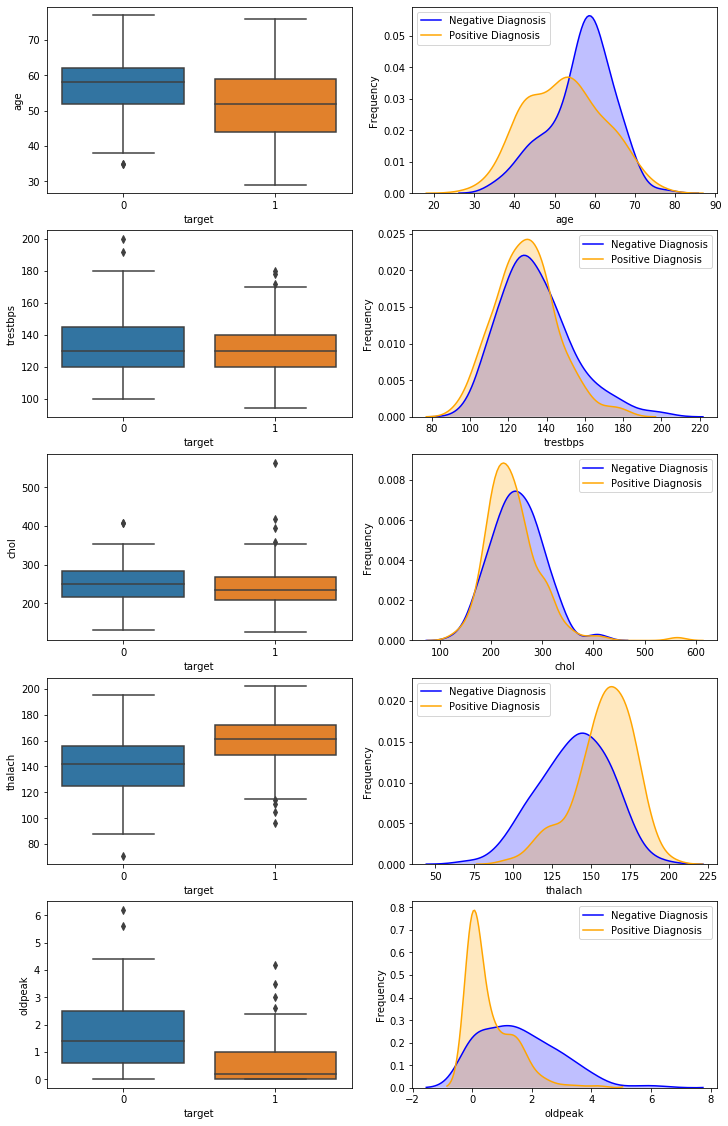

In [18]:
plt.figure(figsize=(12, 24))
count = 1
for col in num_cols:
    plt.subplot(6, 2, count)
    sns.boxplot(x='target', y=col, data=df)
    count +=1
    plt.subplot(6, 2, count)
    
    g = sns.kdeplot(df[col][(df["target"] == 0) & (df[col].notnull())], color="Blue", shade = True)
    g = sns.kdeplot(df[col][(df["target"] == 1) & (df[col].notnull())], ax =g, color="Orange", shade= True)
    g.set_xlabel(col)
    g.set_ylabel("Frequency")
    g = g.legend(["Negative Diagnosis","Positive Diagnosis"])
    count+=1

Seeing the data in this manner helps a lot. With a better understanding of our dataset, let's proceed with building the SVM classifier.

## 4. Build SVM Classifier

Let's set up our attribute matrix, X, and the target vector, y. In some problems, we have to build these matrices ourselves by scanning for attribute values via language processing, text manipulation, etc. Fortunately, in this problem, we already have all of the data in the format we need, and it's also labeled.

In [19]:
# Set up attribute matrix, X
df_X = df.drop(columns=['target'])
X = df_X.to_numpy()

# Set up target vector, y
df_y = df['target']
y = df_y.to_numpy()

Next, let's split this dataset into a training set and a test set.

In [20]:
from sklearn.model_selection import train_test_split

# Break up the dataset into a training set (80% of the data) and a test set (20% of the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

Finally, let's build our SVM classifier. We'll use the radial basis function kernel, or "rbf", which is very similar to the Gaussian kernel that we used above (the distinction is the manner in which each algorithm applies regularization). Below is the equation for the rbf kernel, where the factor in the numerator is the Euclidian distance between points $x_i$ and $x_j$ and the sigma factor in the denomenator is a variance hyperparameter.

<img src="2020-12-17 rbf kernel.PNG" align="center"/>

In [21]:
# Set our C and sigma values
C = 1
sigma = 0.1

# Build and train the SVM classifier
clf = svm.SVC(C=C, kernel='rbf', tol=1e-3, max_iter=200, gamma = sigma)
model = clf.fit(X_train, y_train)

That's it! Our SVM classifier has completed training.

## 5. Analyze Results

With our model trained, let's measure it's accuracy on the training set.

In [22]:
p = model.predict(X_train)
print('Training Accuracy: %.2f %%' %(np.mean(np.double(p == y_train)) * 100))

Training Accuracy: 100.00 %


Not bad! Now let's put it to the real test: how well does it perform on the test set?

In [23]:
p = model.predict(X_test)
print('Test Set Accuracy: %.2f %%' %(np.mean(np.double(p == y_test)) * 100))

Test Set Accuracy: 57.38 %


... not good. This means we overfitted the model to the training set det, so much so that it perfectly predicts samples it already knows but doesn't predict unknown samples with similar accuracy. Let's first tune the hyperparameters of this model to see if we can dial it in a bit better. We'll assess the training set accuracy and test set accuracy over a range of C and sigma values.

In [24]:
# Set up numpy arrays to hold results
results_train = np.zeros((10, 8))
results_test = np.zeros((10,8))

# Define our C and sigma values
c = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
sig = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

# Iterate through all C and sigma values and identify training and test accuracies
for i in range(len(c)):
    for j in range(len(sig)):
        clf = svm.SVC(C=c[i], kernel = 'rbf', tol=1e-3, max_iter=200, gamma=sig[j])
        model = clf.fit(X_train, y_train)
        p = model.predict(X_train)
        acc = np.mean(np.double(p == y_train))*100
        results_train[i][j] = acc
        p = model.predict(X_test)
        acc = np.mean(np.double(p == y_test))*100
        results_test[i][j] = acc

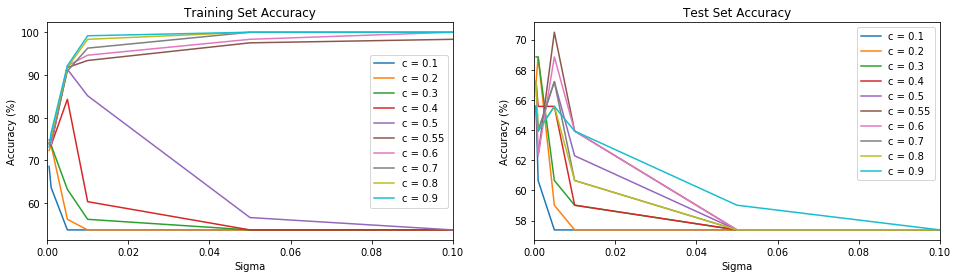

In [25]:
# Size the overall plot
plt.figure(figsize=(16,4))

# Subplot 1 = Training Set Accuracy
plt.subplot(1,2,1)
for i in range(len(c)):
    plt.plot(sig, results_train[i], label='c = {}'.format(c[i]))
plt.xlim(0,0.1)
plt.legend()
plt.title("Training Set Accuracy")
plt.xlabel("Sigma")
plt.ylabel("Accuracy (%)")

# Subplot 2 = Test Set Accuracy
plt.subplot(1,2,2)
for i in range(len(c)):
    plt.plot(sig, results_test[i], label='c = {}'.format(c[i]))
plt.xlim(0,0.1)
plt.legend()
plt.title("Test Set Accuracy")
plt.xlabel("Sigma")
plt.ylabel("Accuracy (%)")

# Show the plots
plt.show()

From the plot above, we can see that our optimal values are C = 0.55 and sigma = 0.005. Let's give that a shot and see how the model performs.

In [26]:
# Set our C and sigma values
C = 0.55
sigma = 0.005

# Build and train the SVM classifier
clf = svm.SVC(C=C, kernel='rbf', tol=1e-3, max_iter=200, gamma = sigma)
model = clf.fit(X_train, y_train)

# Assess training set accuracy
p = model.predict(X_train)
print('Training Accuracy: %.2f %%' %(np.mean(np.double(p == y_train)) * 100))

# Assess test set accuracy
p = model.predict(X_test)
print('Test Set Accuracy: %.2f %%' %(np.mean(np.double(p == y_test)) * 100))

Training Accuracy: 91.74 %
Test Set Accuracy: 70.49 %


Much improved. From those numbers, we know we've mitigated the issue of overfitting the model to the training set data, even if our test set accuracy isn't as high as we may prefer. This can be due to multiple factors, but two of the most likely are:

(1) The attributes selected are not perfectly correlated to outcomes, and therefore cannot be heavily relied upon to make perfect predictions, or 

(2) We need more data. This entire dataset only included 303 samples, so we likely need more data to reduce our uncertainty

## 6. Conclusions

The results above show that a simple SVM classifier is able to predict the correct diagnosis for heart disease in 70.49% of cases, based on other patient health information. This may or may not be acceptable - it depends on the customer's needs and the use case. If this model acts as a pre-appointment data point for a doctor to review prior to meeting with a patient, perhaps 70.49% is accurate enough to properly inform the doctor before they make the final decision. If this model were used by an online healthcare company to make diagnoses remotely, 70.49% is likely not high enough (particularly with the severity of the diagnosis being heart disease or no heart disease), and the model would need to be improved before deployment.

## Acknowledgements

Dataset Creators:
Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Dataset Donor:
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779